### Import FastText Embedding

Environment: Google colab

In [1]:
!git clone https://github.com/TranTheHung2312332/personal-sentiment-analysis.git
!cp -r personal-sentiment-analysis/. .

Cloning into 'personal-sentiment-analysis'...
remote: Enumerating objects: 86, done.
remote: Total 86 (delta 0), reused 0 (delta 0), pack-reused 86 (from 1)
Receiving objects: 100% (86/86), 77.55 MiB | 10.54 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (32/32), done.


In [2]:
import torch

ckpt = torch.load("model/embedding.pt", map_location="cpu")

embedding_matrix = ckpt["embedding"]
word2idx = ckpt["word2idx"]

In [3]:
vocab_size, embed_dim = embedding_matrix.shape
vocab_size, embed_dim

(53110, 300)

### Declare Dataset

In [ ]:
from torch.utils.data import Dataset
import re

class SentimentDataset(Dataset):
    def __init__(self, dataframe, word2idx, max_len=128):
        self.df = dataframe
        self.word2idx = word2idx
        self.max_len = max_len


    def tokenize(self, text):
        patterns = [
            r"\[[A-Z_]+\]",
            r"<\/?[\w_]+>",
            r"\w+",
            r"[?!]{2,}",
            r"\.{3,}",
            r"[^\w\s]"
        ]

        combined = re.compile("|".join(patterns), re.UNICODE)

        return combined.findall(text)


    def encode_text(self, text):
        tokens = self.tokenize(text)
        ids = [self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens]
        ids = ids[:self.max_len]

        return ids + [self.word2idx['<pad>']] * (self.max_len - len(ids))


    def __len__(self):
        return len(self.df)


    def __getitem__(self, index):
        row = self.df.loc[index]

        text_ids = torch.tensor(self.encode_text(row['text']))
        extra_feats = torch.tensor([
            row["ex_intensity"],
            row["emoji_score"],
            row["all_uppercase"],
            row["uppercase_ratio"]]
        , dtype=torch.float32)

        return text_ids, extra_feats, torch.tensor(int(row['label']), dtype=torch.long)


### Declare Model

In [5]:
import torch
from torch import nn
import torch.nn.functional as F


class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, lstm_out, mask):
        # lstm_out: (B, T, H)
        # mask: (B, T, 1)

        scores = self.attn(lstm_out).squeeze(-1)  # (B, T)
        scores = scores.masked_fill(mask.squeeze(-1) == 0, -1e9)

        attn_weights = F.softmax(scores, dim=1)  # (B, T)
        attn_weights = self.dropout(attn_weights)
        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)

        return context, attn_weights


In [6]:
class Model(nn.Module):
    def __init__(self, embedding_matrix, lstm_hidden=128, lstm_layers=1, num_classes=3, embed_proj_size=128):
        super().__init__()
        self.embedding_matrix = embedding_matrix
        self.num_classes = num_classes

        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), padding_idx=0, freeze=True)

        self.embed_proj = nn.Sequential(
            nn.Linear(embedding_matrix.size(1), embed_proj_size),
            nn.LayerNorm(embed_proj_size),
            nn.Dropout(0.3)
        )

        self.lstm = nn.LSTM(
            input_size=embed_proj_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(0.3)

        self.attention = AttentionPooling(lstm_hidden * 2)

        self.layernorm = nn.LayerNorm(lstm_hidden * 2 + 4)

        self.mlp = nn.Sequential(
            nn.Linear(lstm_hidden * 2 + 4, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, text_ids, extra_feats):
        # Embedding
        x = self.embedding(text_ids)  # (B, T, E)

        x = self.embed_proj(x)

        # LSTM
        lstm_out, _ = self.lstm(x)  # (B, T, 2H)
        lstm_out = self.dropout(lstm_out)

        # Mask padding
        mask = (text_ids != 0).unsqueeze(-1)  # (B, T, 1)

        # Attention
        context, attn_weights = self.attention(lstm_out, mask)

        # Concatenate extra features
        features = torch.cat([context, extra_feats], dim=1)

        features = self.layernorm(features)

        logits = self.mlp(features)

        return logits

### Training config

In [7]:
import pandas as pd

train_df = pd.read_csv('data/preprocessed/train.csv')

In [8]:
from torch.utils.data import DataLoader

MAX_LEN = 128
BATCH_SIZE = 128

train_dataset = SentimentDataset(train_df, word2idx, max_len=MAX_LEN)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [52]:
LSTM_HIDDEN = 128
LSTM_LAYERS = 1
EMBED_PROJ_SIZE = 128

model = Model(embedding_matrix, lstm_hidden=LSTM_HIDDEN, lstm_layers=LSTM_LAYERS, embed_proj_size=EMBED_PROJ_SIZE).to('cuda' if torch.cuda.is_available() else 'cpu')

/tmp/ipython-input-2893275946.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), padding_idx=0, freeze=True)


In [53]:
import torch.optim as optim

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,
    weight_decay=3e-4
)


criterion = nn.CrossEntropyLoss()

In [54]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    total = 0
    correct = 0

    for text_ids, extra_feats, labels in tqdm(dataloader, desc='Epoch training'):
        text_ids = text_ids.to(device)
        extra_feats = extra_feats.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(text_ids, extra_feats)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total

    return total_loss / len(dataloader), acc


### Evaluate config

In [55]:
val_df = pd.read_csv('data/preprocessed/val.csv')
val_dataset = SentimentDataset(val_df, word2idx, max_len=MAX_LEN)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate(model, dataloader, criterion, device, threshold=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for text_ids, extra_feats, labels in tqdm(dataloader, desc='Validating'):
            text_ids = text_ids.to(device)
            extra_feats = extra_feats.to(device)
            labels = labels.to(device)

            logits = model(text_ids, extra_feats)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            all_labels.extend(labels.cpu().tolist())

            probs = F.softmax(logits, dim=1)

            if threshold is None:
                preds = torch.argmax(probs, dim=1)
            else:
                preds = []

                for p in probs:
                    prob_pos = p[0].item()
                    prob_neu = p[1].item()
                    prob_neg = p[2].item()

                    if prob_pos >= threshold.get('pos', 1/3) and prob_pos >= prob_neg:
                        preds.append(0)
                    elif prob_neg >= threshold.get('neg', 1/3) and prob_neg > prob_pos:
                        preds.append(2)
                    else:
                        preds.append(1)

            all_preds.extend(preds)

    avg_loss = total_loss / len(dataloader)

    acc = accuracy_score(all_labels, all_preds)

    precision = precision_score(all_labels, all_preds, average=None, labels=[0,1,2])
    recall = recall_score(all_labels, all_preds, average=None, labels=[0,1,2])

    precision_pos, precision_neu, precision_neg = precision
    recall_pos, recall_neu, recall_neg = recall

    return {
        'loss': avg_loss,
        'acc': acc,
        'precision_pos': precision_pos,
        'precision_neg': precision_neg,
        'precision_neu': precision_neu,
        'recall_pos': recall_pos,
        'recall_neg': recall_neg,
        'recall_neu': recall_neu,
    }


### Loop

In [57]:
import copy

EPOCHS = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

history_train_acc = []
history_train_loss = []
history_val_acc = []
history_val_loss = []

val_states = []

for epoch in range(EPOCHS):

    train_loss, train_acc = train(
        model,
        train_loader,
        optimizer,
        criterion,
        device
    )

    history_train_loss.append(train_loss)
    history_train_acc.append(train_acc)

    val = evaluate(
        model,
        val_loader,
        criterion,
        device
    )

    val['model_state'] = copy.deepcopy(model.state_dict())
    val_states.append(val)

    history_val_loss.append(val['loss'])
    history_val_acc.append(val['acc'])

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val['loss']:.4f} | "
        f"Val Acc: {val['acc']:.4f}"
        "\n--------------------------------------------\n"
    )

Validating: 100%|██████████| 68/68 [00:02<00:00, 30.72it/s]


Epoch 1/20 | Train Loss: 0.9209 | Train Acc: 0.5587 | Val Loss: 0.7645 | Val Acc: 0.6617
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 39.81it/s]


Epoch 2/20 | Train Loss: 0.7839 | Train Acc: 0.6578 | Val Loss: 0.6953 | Val Acc: 0.7003
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 39.99it/s]


Epoch 3/20 | Train Loss: 0.7416 | Train Acc: 0.6801 | Val Loss: 0.6727 | Val Acc: 0.7105
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:02<00:00, 28.69it/s]


Epoch 4/20 | Train Loss: 0.7173 | Train Acc: 0.6917 | Val Loss: 0.6725 | Val Acc: 0.7135
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:03<00:00, 22.57it/s]


Epoch 5/20 | Train Loss: 0.7024 | Train Acc: 0.6987 | Val Loss: 0.6646 | Val Acc: 0.7079
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:02<00:00, 33.72it/s]


Epoch 6/20 | Train Loss: 0.6884 | Train Acc: 0.7062 | Val Loss: 0.6546 | Val Acc: 0.7206
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 41.85it/s]


Epoch 7/20 | Train Loss: 0.6810 | Train Acc: 0.7086 | Val Loss: 0.6558 | Val Acc: 0.7158
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 43.04it/s]


Epoch 8/20 | Train Loss: 0.6712 | Train Acc: 0.7120 | Val Loss: 0.6437 | Val Acc: 0.7218
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 39.58it/s]


Epoch 9/20 | Train Loss: 0.6666 | Train Acc: 0.7153 | Val Loss: 0.6392 | Val Acc: 0.7275
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 40.47it/s]


Epoch 10/20 | Train Loss: 0.6578 | Train Acc: 0.7195 | Val Loss: 0.6367 | Val Acc: 0.7278
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 39.83it/s]


Epoch 11/20 | Train Loss: 0.6517 | Train Acc: 0.7228 | Val Loss: 0.6337 | Val Acc: 0.7277
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 37.33it/s]


Epoch 12/20 | Train Loss: 0.6464 | Train Acc: 0.7261 | Val Loss: 0.6311 | Val Acc: 0.7323
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:02<00:00, 24.68it/s]


Epoch 13/20 | Train Loss: 0.6389 | Train Acc: 0.7278 | Val Loss: 0.6271 | Val Acc: 0.7353
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 41.29it/s]


Epoch 14/20 | Train Loss: 0.6362 | Train Acc: 0.7295 | Val Loss: 0.6369 | Val Acc: 0.7267
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 42.39it/s]


Epoch 15/20 | Train Loss: 0.6274 | Train Acc: 0.7309 | Val Loss: 0.6337 | Val Acc: 0.7316
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:02<00:00, 33.71it/s]


Epoch 16/20 | Train Loss: 0.6262 | Train Acc: 0.7343 | Val Loss: 0.6351 | Val Acc: 0.7363
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 40.97it/s]


Epoch 17/20 | Train Loss: 0.6193 | Train Acc: 0.7348 | Val Loss: 0.6319 | Val Acc: 0.7323
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:02<00:00, 30.00it/s]


Epoch 18/20 | Train Loss: 0.6136 | Train Acc: 0.7379 | Val Loss: 0.6362 | Val Acc: 0.7352
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 41.43it/s]


Epoch 19/20 | Train Loss: 0.6105 | Train Acc: 0.7396 | Val Loss: 0.6351 | Val Acc: 0.7342
--------------------------------------------



Validating: 100%|██████████| 68/68 [00:01<00:00, 41.95it/s]

Epoch 20/20 | Train Loss: 0.6066 | Train Acc: 0.7425 | Val Loss: 0.6323 | Val Acc: 0.7303
--------------------------------------------



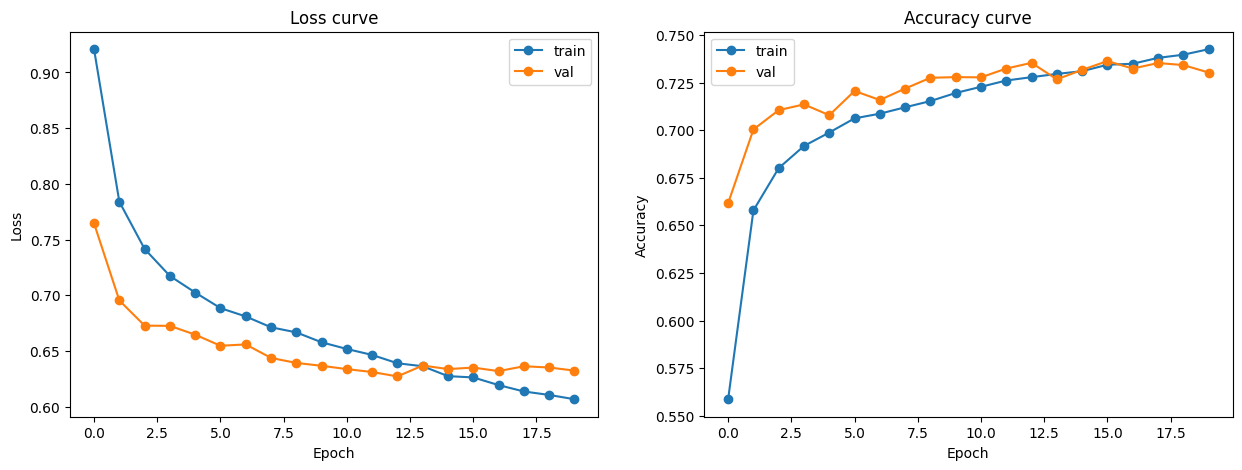

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history_train_loss, label='train', marker='o')
ax[0].plot(history_val_loss, label='val', marker='o')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss curve')
ax[0].legend()

ax[1].plot(history_train_acc, label='train', marker='o')
ax[1].plot(history_val_acc, label='val', marker='o')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy curve')
ax[1].legend()

plt.show()


### evaluate

In [59]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for text_ids, extra_feats, labels in val_loader:
        text_ids = text_ids.to(device)
        extra_feats = extra_feats.to(device)
        labels = labels.to(device)

        logits = model(text_ids, extra_feats)
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Predictions collected for validation set.")

Predictions collected for validation set.


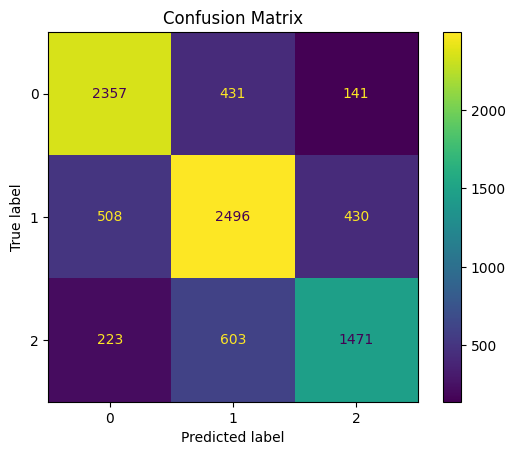

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [67]:
val_df = pd.DataFrame(val_states).drop(columns=['model_state'])
val_df.sort_values(by='recall_neg', ascending=False)

,loss,acc,precision_pos,precision_neg,precision_neu,recall_pos,recall_neg,recall_neu
0,0.764541,0.661663,0.700732,0.560690,0.728042,0.784227,0.707880,0.526209
13,0.636896,0.726674,0.769156,0.673904,0.725453,0.805394,0.702656,0.675597
7,0.643713,0.721824,0.772274,0.661290,0.720161,0.793103,0.696125,0.678218
10,0.633658,0.727714,0.781029,0.676910,0.715909,0.792762,0.690466,0.697146
18,0.635132,0.734180,0.809711,0.695420,0.699723,0.774326,0.680888,0.735585
8,0.639215,0.727483,0.797355,0.693702,0.694391,0.761693,0.666522,0.739080
17,0.636220,0.735219,0.825826,0.708080,0.687678,0.751110,0.659991,0.771986
16,0.631876,0.732333,0.803824,0.703497,0.694392,0.775009,0.656944,0.746360
11,0.631060,0.732333,0.782255,0.710514,0.704127,0.788665,0.656073,0.735294
12,0.627128,0.735335,0.794057,0.716810,0.699619,0.784568,0.653461,0.748107


In [68]:
val_df.iloc[17]

,17
loss,0.636220
acc,0.735219
precision_pos,0.825826
precision_neg,0.708080
precision_neu,0.687678
recall_pos,0.751110
recall_neg,0.659991
recall_neu,0.771986


In [70]:
model.load_state_dict(val_states[17]['model_state'])

<All keys matched successfully>

In [98]:
threshold = {
    'pos': 0.28,
    'neg': 0.28
}

evaluate(model, val_loader, criterion, 'cuda', threshold)

Validating: 100%|██████████| 68/68 [00:03<00:00, 18.56it/s]


{'loss': 0.6362198034630102,
 'acc': 0.7087759815242495,
 'precision_pos': np.float64(0.7554790231684408),
 'precision_neg': np.float64(0.6039024390243902),
 'precision_neu': np.float64(0.7812630698452531),
 'recall_pos': np.float64(0.8238306589279618),
 'recall_neg': np.float64(0.8084457988680888),
 'recall_neu': np.float64(0.5439720442632499)}

### Save best model

In [100]:
torch.save(model.state_dict(), 'model/clf.pt')